# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.54KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

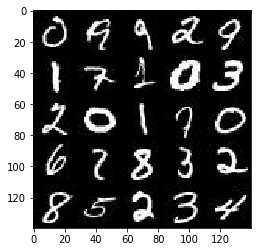

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

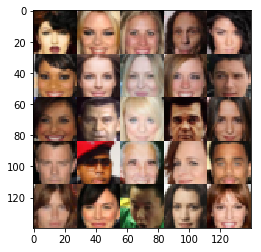

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [15]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputImages = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels), name = "input_images")
    zInput = tf.placeholder(tf.float32, shape = (None, z_dim), name = "z_input")
    learningRate = tf.placeholder(tf.float32, name = "learning_rate")
    
    return inputImages, zInput, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.05
    
    with tf.variable_scope("discriminator", reuse = reuse) as disc_scope:
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        # 4096
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.05
    
    with tf.variable_scope('generator', reuse = (not is_train)):
    
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*384)
        x1 = tf.reshape(x1, (-1, 7, 7, 384))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.shape)
        # 7x7#384

        x2 = tf.layers.conv2d_transpose(x1, 192, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)
        # 14x14#192

        x3 = tf.layers.conv2d_transpose(x2, 96, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
        #28x28x96

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28 x 28 x out_channel_dim

        out = tf.tanh(logits)

        return out
    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    labels = tf.ones_like(d_model_real) * 0.95

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=labels)
        )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    print(data_shape)
    
    tf.reset_default_graph()
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_images *= 2.0
                
                # Sample random noize
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z })
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images, input_z: batch_z })
                
                if steps % 10 == 0:
                    # Show loss
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z,  data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.4047... Generator Loss: 2.0028
Epoch 1/2... Discriminator Loss: 0.4722... Generator Loss: 1.8196
Epoch 1/2... Discriminator Loss: 0.7915... Generator Loss: 1.3742
Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 0.9189
Epoch 1/2... Discriminator Loss: 0.7680... Generator Loss: 1.5965
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 1.4752
Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 1.4244
Epoch 1/2... Discriminator Loss: 1.1213... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.2095... Generator Loss: 0.6602


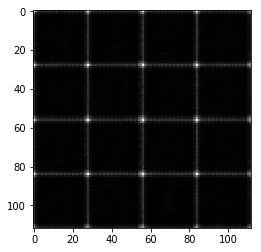

Epoch 1/2... Discriminator Loss: 1.2534... Generator Loss: 1.9729
Epoch 1/2... Discriminator Loss: 1.0096... Generator Loss: 1.1664
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 1.0555
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 1.1120
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 0.6883
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 0.5637
Epoch 1/2... Discriminator Loss: 1.5835... Generator Loss: 0.4225
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 1.9801
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 1.4566
Epoch 1/2... Discriminator Loss: 0.9479... Generator Loss: 1.4083


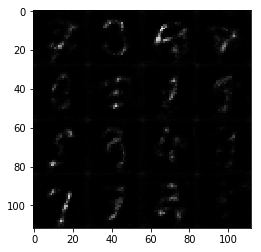

Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 2.2430
Epoch 1/2... Discriminator Loss: 0.9379... Generator Loss: 1.0295
Epoch 1/2... Discriminator Loss: 1.0160... Generator Loss: 1.6069
Epoch 1/2... Discriminator Loss: 0.9673... Generator Loss: 1.0765
Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.1037... Generator Loss: 0.7056
Epoch 1/2... Discriminator Loss: 0.9596... Generator Loss: 0.8354
Epoch 1/2... Discriminator Loss: 0.9489... Generator Loss: 1.2559
Epoch 1/2... Discriminator Loss: 0.8937... Generator Loss: 1.1077
Epoch 1/2... Discriminator Loss: 1.1324... Generator Loss: 0.8800


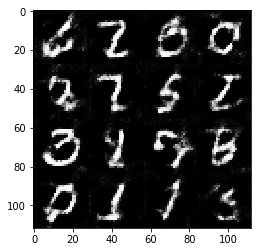

Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 1.7356
Epoch 1/2... Discriminator Loss: 0.9043... Generator Loss: 1.5587
Epoch 1/2... Discriminator Loss: 1.1825... Generator Loss: 2.1373
Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 0.6500
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 1.5052
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 1.5253
Epoch 1/2... Discriminator Loss: 1.1935... Generator Loss: 2.1465
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 0.9759... Generator Loss: 0.9626


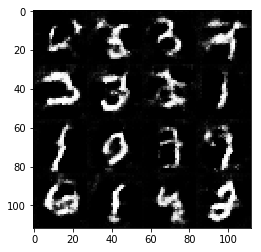

Epoch 1/2... Discriminator Loss: 0.9130... Generator Loss: 1.1345
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 0.7578
Epoch 1/2... Discriminator Loss: 0.9060... Generator Loss: 1.7566
Epoch 1/2... Discriminator Loss: 1.1151... Generator Loss: 0.6965
Epoch 1/2... Discriminator Loss: 0.9779... Generator Loss: 1.2012
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 1.7423
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 1.3965
Epoch 1/2... Discriminator Loss: 1.3111... Generator Loss: 0.4864
Epoch 1/2... Discriminator Loss: 1.0397... Generator Loss: 1.2531
Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 0.6449


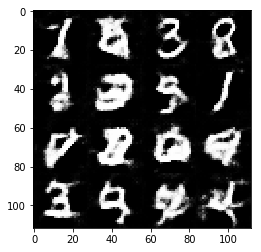

Epoch 1/2... Discriminator Loss: 1.1146... Generator Loss: 0.6806
Epoch 1/2... Discriminator Loss: 0.9237... Generator Loss: 1.3002
Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 0.7511
Epoch 1/2... Discriminator Loss: 0.9590... Generator Loss: 1.2107
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 1.3655
Epoch 1/2... Discriminator Loss: 1.5584... Generator Loss: 0.3576
Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 1.9923
Epoch 1/2... Discriminator Loss: 0.9409... Generator Loss: 1.1289
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.4607


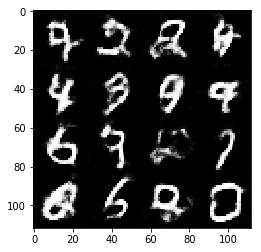

Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 0.5497
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 0.9309... Generator Loss: 1.0423
Epoch 1/2... Discriminator Loss: 0.9331... Generator Loss: 1.1008
Epoch 1/2... Discriminator Loss: 1.0631... Generator Loss: 0.8083
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.5850
Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 1.0178
Epoch 1/2... Discriminator Loss: 0.9571... Generator Loss: 1.2908
Epoch 1/2... Discriminator Loss: 1.1825... Generator Loss: 0.6082
Epoch 1/2... Discriminator Loss: 0.8873... Generator Loss: 1.1375


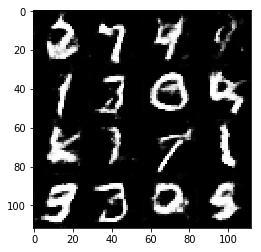

Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.5112
Epoch 1/2... Discriminator Loss: 0.9610... Generator Loss: 1.3315
Epoch 1/2... Discriminator Loss: 1.2155... Generator Loss: 0.6137
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 1.4270
Epoch 1/2... Discriminator Loss: 1.0496... Generator Loss: 0.7012
Epoch 1/2... Discriminator Loss: 0.9142... Generator Loss: 1.1107
Epoch 1/2... Discriminator Loss: 0.8140... Generator Loss: 1.1749
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 1.1678
Epoch 1/2... Discriminator Loss: 1.3313... Generator Loss: 2.9837
Epoch 1/2... Discriminator Loss: 0.8300... Generator Loss: 1.2964


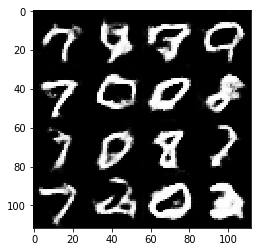

Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 0.8814
Epoch 1/2... Discriminator Loss: 0.9092... Generator Loss: 1.6263
Epoch 1/2... Discriminator Loss: 0.8988... Generator Loss: 1.0252
Epoch 1/2... Discriminator Loss: 2.1479... Generator Loss: 0.2134
Epoch 1/2... Discriminator Loss: 1.0247... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.0462
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.0424
Epoch 1/2... Discriminator Loss: 0.8227... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 0.7614
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 0.6921


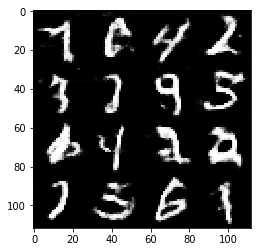

Epoch 1/2... Discriminator Loss: 0.9451... Generator Loss: 0.9372
Epoch 1/2... Discriminator Loss: 0.8391... Generator Loss: 1.2101
Epoch 1/2... Discriminator Loss: 1.8816... Generator Loss: 0.2756
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 0.8501
Epoch 2/2... Discriminator Loss: 1.0244... Generator Loss: 0.7872
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 0.9922
Epoch 2/2... Discriminator Loss: 0.7666... Generator Loss: 1.4881
Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 1.5343
Epoch 2/2... Discriminator Loss: 0.7505... Generator Loss: 1.1722
Epoch 2/2... Discriminator Loss: 0.9467... Generator Loss: 0.8893


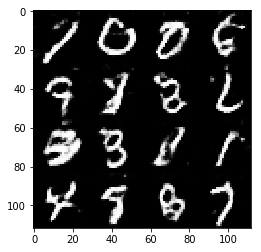

Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 0.7261
Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 1.0776
Epoch 2/2... Discriminator Loss: 0.7889... Generator Loss: 1.3647
Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 1.6963
Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 1.3136
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 0.8449
Epoch 2/2... Discriminator Loss: 1.0605... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 0.8509... Generator Loss: 1.7916
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 0.8257
Epoch 2/2... Discriminator Loss: 1.1488... Generator Loss: 0.6118


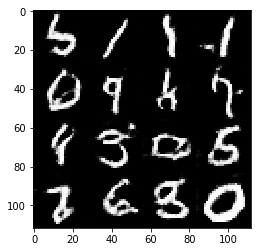

Epoch 2/2... Discriminator Loss: 0.9667... Generator Loss: 0.8944
Epoch 2/2... Discriminator Loss: 0.7865... Generator Loss: 1.2338
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 0.8502
Epoch 2/2... Discriminator Loss: 0.9038... Generator Loss: 0.9738
Epoch 2/2... Discriminator Loss: 0.8484... Generator Loss: 1.1773
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 2.6691
Epoch 2/2... Discriminator Loss: 0.8482... Generator Loss: 1.2113
Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 1.0943
Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 1.8594


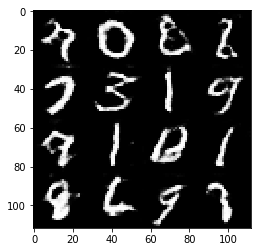

Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 0.9402
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 0.9969
Epoch 2/2... Discriminator Loss: 0.8452... Generator Loss: 1.0996
Epoch 2/2... Discriminator Loss: 0.8846... Generator Loss: 0.9138
Epoch 2/2... Discriminator Loss: 0.8483... Generator Loss: 1.0650
Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 0.8574
Epoch 2/2... Discriminator Loss: 0.9090... Generator Loss: 1.2677
Epoch 2/2... Discriminator Loss: 0.7208... Generator Loss: 1.2234
Epoch 2/2... Discriminator Loss: 0.7704... Generator Loss: 1.1443
Epoch 2/2... Discriminator Loss: 0.8953... Generator Loss: 2.1957


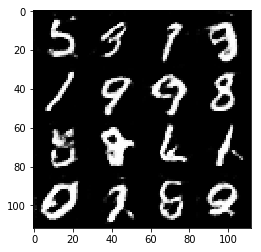

Epoch 2/2... Discriminator Loss: 0.8445... Generator Loss: 1.5598
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 0.8359
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 0.9774
Epoch 2/2... Discriminator Loss: 1.0648... Generator Loss: 0.7758
Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 0.8202
Epoch 2/2... Discriminator Loss: 0.8151... Generator Loss: 1.0727
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 0.8843
Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 0.9567
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 0.9488
Epoch 2/2... Discriminator Loss: 0.7732... Generator Loss: 1.9045


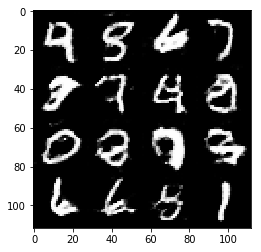

Epoch 2/2... Discriminator Loss: 1.0340... Generator Loss: 0.7593
Epoch 2/2... Discriminator Loss: 1.2484... Generator Loss: 0.5759
Epoch 2/2... Discriminator Loss: 0.9758... Generator Loss: 1.0135
Epoch 2/2... Discriminator Loss: 0.8735... Generator Loss: 1.1029
Epoch 2/2... Discriminator Loss: 1.0511... Generator Loss: 1.3602
Epoch 2/2... Discriminator Loss: 0.8720... Generator Loss: 1.3333
Epoch 2/2... Discriminator Loss: 0.8763... Generator Loss: 0.9444
Epoch 2/2... Discriminator Loss: 0.7196... Generator Loss: 1.3648
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 1.0728
Epoch 2/2... Discriminator Loss: 0.8419... Generator Loss: 1.5991


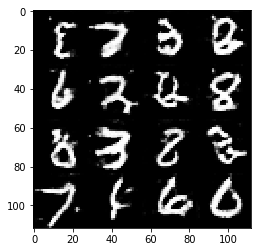

Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 0.6412
Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 0.9944
Epoch 2/2... Discriminator Loss: 0.6964... Generator Loss: 1.2313
Epoch 2/2... Discriminator Loss: 1.1562... Generator Loss: 2.5179
Epoch 2/2... Discriminator Loss: 0.9395... Generator Loss: 0.9051
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 0.8415
Epoch 2/2... Discriminator Loss: 0.7133... Generator Loss: 1.3551
Epoch 2/2... Discriminator Loss: 1.1075... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 1.0167... Generator Loss: 1.9378
Epoch 2/2... Discriminator Loss: 0.7843... Generator Loss: 1.1526


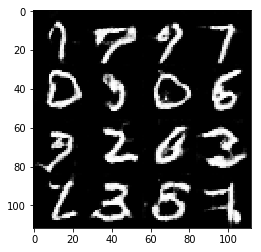

Epoch 2/2... Discriminator Loss: 0.7471... Generator Loss: 1.1280
Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 1.0742
Epoch 2/2... Discriminator Loss: 0.7309... Generator Loss: 1.2476
Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 1.0746
Epoch 2/2... Discriminator Loss: 1.2529... Generator Loss: 0.5375
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 0.9400
Epoch 2/2... Discriminator Loss: 0.7759... Generator Loss: 1.2194
Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 1.1988
Epoch 2/2... Discriminator Loss: 0.7041... Generator Loss: 1.3558
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 0.7978


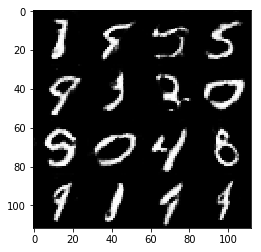

Epoch 2/2... Discriminator Loss: 0.7292... Generator Loss: 1.1923
Epoch 2/2... Discriminator Loss: 0.8274... Generator Loss: 1.0165
Epoch 2/2... Discriminator Loss: 1.6473... Generator Loss: 0.3367
Epoch 2/2... Discriminator Loss: 1.1010... Generator Loss: 1.7337
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 1.6604
Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 0.7496
Epoch 2/2... Discriminator Loss: 0.9588... Generator Loss: 0.8454
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.1192
Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 0.7949
Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 1.0135


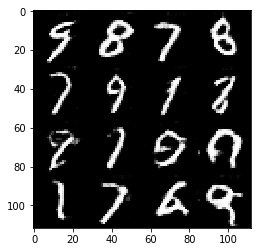

Epoch 2/2... Discriminator Loss: 0.6674... Generator Loss: 1.4982
Epoch 2/2... Discriminator Loss: 0.7371... Generator Loss: 1.1543
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 1.1054
Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 1.4038
Epoch 2/2... Discriminator Loss: 0.7383... Generator Loss: 1.2809
Epoch 2/2... Discriminator Loss: 1.2749... Generator Loss: 0.5333
Epoch 2/2... Discriminator Loss: 0.8709... Generator Loss: 0.9936


IndexError: list index out of range

In [30]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 1.3629
Epoch 1/1... Discriminator Loss: 0.4392... Generator Loss: 1.9139
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 3.1399
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 2.1929
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 2.1423
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 1.3584
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.1561


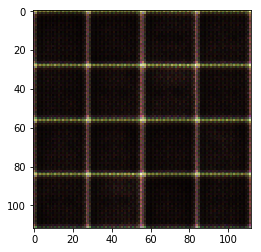

Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 1.9165
Epoch 1/1... Discriminator Loss: 0.7759... Generator Loss: 1.6799
Epoch 1/1... Discriminator Loss: 0.7280... Generator Loss: 2.5354
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.5803
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 2.9979
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 0.4421... Generator Loss: 2.6852
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 1.8706
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 1.6404
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 2.6434


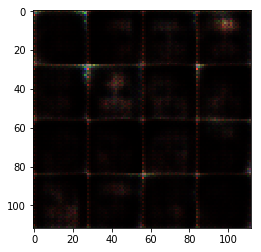

Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.4705
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.2378
Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 1.1549
Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 1.8477
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 2.2392
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 0.9332


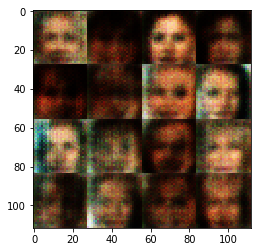

Epoch 1/1... Discriminator Loss: 0.4343... Generator Loss: 5.1376
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 2.4993
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 3.0204
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 1.3892
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 1.4288
Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 3.2141
Epoch 1/1... Discriminator Loss: 0.5991... Generator Loss: 1.5770
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 2.4178


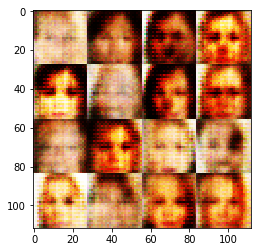

Epoch 1/1... Discriminator Loss: 0.4705... Generator Loss: 3.4938
Epoch 1/1... Discriminator Loss: 0.2722... Generator Loss: 3.8445
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 2.8925
Epoch 1/1... Discriminator Loss: 0.3125... Generator Loss: 3.5582
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 3.2129
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 2.1066
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.4142


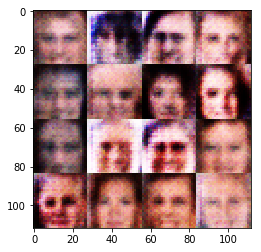

Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 1.7504
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 3.5908
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 1.9761
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 2.2052
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 2.1104
Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 2.9748
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.6421
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.4687
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 1.2823


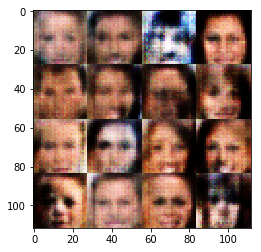

Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 0.4518... Generator Loss: 2.1761
Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 1.7223
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 2.3262
Epoch 1/1... Discriminator Loss: 0.3275... Generator Loss: 3.7216


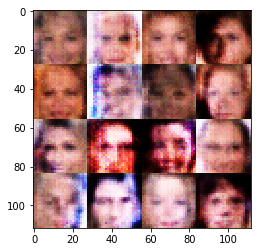

Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 2.3929
Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 3.5339
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 2.2832
Epoch 1/1... Discriminator Loss: 0.4953... Generator Loss: 2.5150
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 0.4434... Generator Loss: 1.8570
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 3.4713
Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 3.8873
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 1.2970


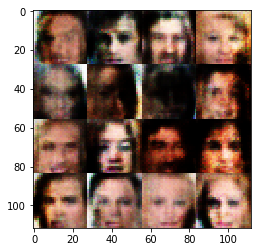

Epoch 1/1... Discriminator Loss: 0.3375... Generator Loss: 2.7544
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 3.2003
Epoch 1/1... Discriminator Loss: 0.3746... Generator Loss: 2.5785
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 2.3709
Epoch 1/1... Discriminator Loss: 0.4068... Generator Loss: 2.3352
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 4.7716
Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 2.0218
Epoch 1/1... Discriminator Loss: 0.5209... Generator Loss: 2.3620
Epoch 1/1... Discriminator Loss: 0.4934... Generator Loss: 2.4751


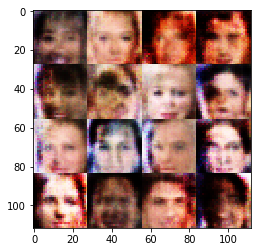

Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 3.0419
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 2.6904
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 1.2729
Epoch 1/1... Discriminator Loss: 0.3933... Generator Loss: 2.5674
Epoch 1/1... Discriminator Loss: 0.5117... Generator Loss: 2.0815
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.0681
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 1.4847
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.4378
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 3.6114


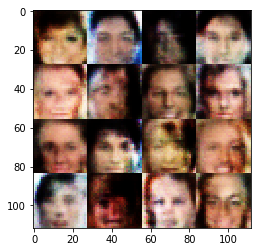

Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 4.1648
Epoch 1/1... Discriminator Loss: 1.7951... Generator Loss: 0.2764


IndexError: list index out of range

In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.